# FreeSolv database
The following shows the result trained on freesolv database. 

In [1]:
%matplotlib inline
from preprocessing import preprocessing
from module import batch_generator, decoder_gru,  autoencoder_gru, VAE_gru, Predictor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
X_onehot_train, X_onehot_test, X_long_train, X_long_test, y_train, y_test, demapping = preprocessing()

std = y_train.std()
mean = y_train.mean()

SAVE_PATH = "data/auto_gru_pred_new"
SAVE_PATH2 = "data/predictor_new"
device = torch.device("cpu")
RNN = autoencoder_gru(23, 14, device)
predictor = Predictor(14)
RNN.load_state_dict(torch.load(SAVE_PATH))
predictor.load_state_dict(torch.load(SAVE_PATH2))

## PCA analysis of encoded vector

In [2]:
import numpy as np

encoding_train = []
for x_long_each in X_long_train:
    # x_onehot_each = x_onehot_each.reshape(x_onehot_each.size(0), 1, -1)
    encoding_each = RNN.encode(x_long_each)[0][-1].reshape(-1)
    encoding_train.append(encoding_each.detach().numpy())

encoding_test = []
for x_long_each in X_long_test:
    # x_onehot_each = x_onehot_each.reshape(x_onehot_each.size(0), 1, -1)
    encoding_each = RNN.encode(x_long_each)[0][-1].reshape(-1)
    encoding_test.append(encoding_each.detach().numpy())

from sklearn.decomposition import PCA
def pca_2nd(X, whiten=False):
    pca = PCA(n_components=2, whiten=whiten)
    components = pca.fit_transform(X)
    print("variance explained: ", pca.explained_variance_ratio_, "  total:", pca.explained_variance_ratio_.sum())
    return components

encoding_test = np.array(encoding_test)
encoding_train = np.array(encoding_train)

pca_test = pca_2nd(encoding_test)
pca_train = pca_2nd(encoding_train)

variance explained:  [0.3329492  0.19018611]   total: 0.5231353
variance explained:  [0.34784412 0.2078271 ]   total: 0.5556712


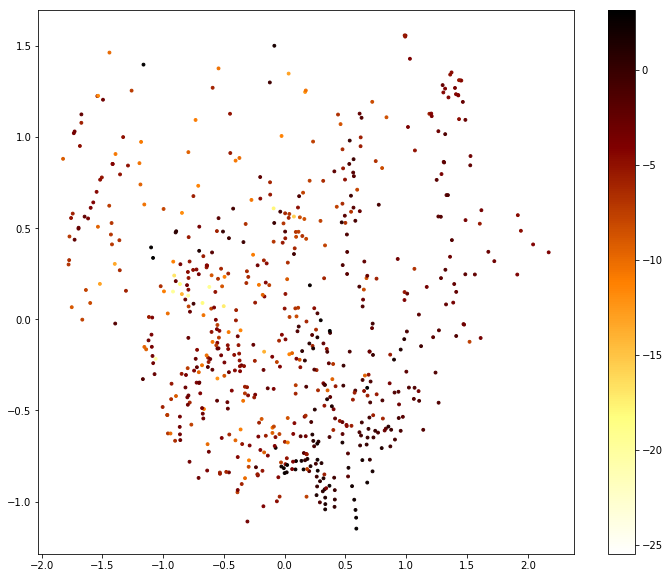

In [10]:
cm = plt.cm.get_cmap('afmhot_r')
plt.figure(figsize=(12, 10))
plt.scatter(pca_train[:,0],pca_train[:,1], s=8, label='train', c=y_train, cmap=cm)
plt.scatter(pca_test[:,0], pca_test[:,1], s=8, label='test', c=y_test, cmap=cm, )
plt.colorbar()

(array([10., 25., 39., 50., 45., 41., 38., 31., 40., 40., 30., 41., 22.,
        21., 10., 17., 10.,  4.]),
 array([-1.14796519, -0.99768207, -0.84739896, -0.69711584, -0.54683272,
        -0.3965496 , -0.24626648, -0.09598337,  0.05429975,  0.20458287,
         0.35486599,  0.50514911,  0.65543222,  0.80571534,  0.95599846,
         1.10628158,  1.2565647 ,  1.40684781,  1.55713093]),
 <a list of 18 Patch objects>)

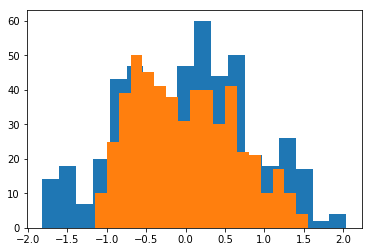

In [4]:
plt.hist(pca_train[:,0], bins=18)
plt.hist(pca_train[:,1], bins=18)

## Prediction Accuracy
The result reaches the 1-class accuracy compared to the benchmark mentioned in paper [MoleculeNet: a benchmark for molecular machine learning](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a?page=search).
However this is still not optimal and there is more to explore about this database.

In [8]:
MSE_f = nn.MSELoss()
result = []
loss_Y_log = 0
relative_error = []
acc1 = 0
acc2 = 0
acc5 = 0
acc10 = 0

for (x_long_each, y_each) in zip(X_long_test,  y_test):
    encoding_each = RNN.encode(x_long_each)[0][-1].reshape(-1)
    y_pred = predictor(encoding_each) * std + mean
    loss_Y_log += MSE_f(y_pred, y_each)
    result.append(y_pred.detach().numpy())
    error = abs((y_each-y_pred)/y_each).item()
    relative_error.append( error )
    if (error < 0.01):
        acc1 += 1
        acc2 += 1
        acc5 += 1
        acc10 += 1
    elif (error < 0.02):
        acc2 += 1
        acc5 += 1
        acc10 += 1
    elif (error < 0.05):
        acc10 += 1
        acc5 += 1
    elif (error < 0.1):
        acc10 += 1
print("RMSE: %.3f" % (loss_Y_log.item() / len(y_test))**0.5 )
print("ARE: %.3f%%" % (sum(relative_error)/len(y_test)*100) )
print("acc1: %d%% acc2: %d%% acc5: %d%% acc10: %d%% " % (acc1*100/len(y_test), acc2*100/len(y_test), acc5*100/len(y_test), acc10*100/len(y_test)))

RMSE: 1.275
ARE: 35.562%
acc1: 2% acc2: 9% acc5: 20% acc10: 34% 


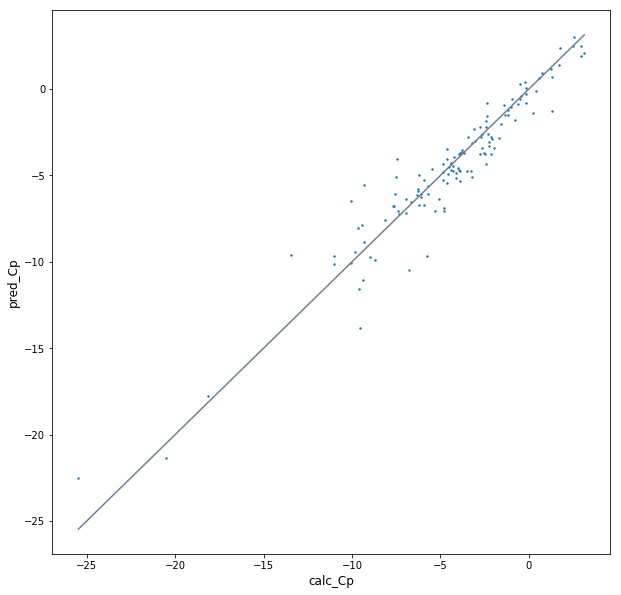

In [6]:
result = np.array(result)
plt.figure(figsize=(10, 10))
plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()],color='slategrey')
plt.scatter( y_test, result, s=2 )
plt.ylabel('pred_', fontsize=12)
plt.xlabel('calc_Cp', fontsize=12)
plt.show()  